# Analyzing tweets

In [1]:
from collections import Counter

import pymongo

import nltk
from nltk.tokenize import TweetTokenizer

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# MongoDB connection data
HOST = '146.148.63.14'
PORT = '27017'
DB_NAME = 'trending'

### Connecting to database

In [3]:
db = None
try:
    db_client = pymongo.MongoClient(HOST + ':' + PORT)
    db = db_client[DB_NAME]
    print('Conecction established successfully!')
except pymongo.errors.ConnectionFailure:
    print('Connection cannot be established')

Conecction established successfully!


In [4]:
HISTORY_COL = db['history']

### Visualizing trends (hashtags and mentions)

In [5]:
hashtags_counter = Counter()
mentions_counter = Counter()

In [6]:
tweets = HISTORY_COL.find({}, {'_id': 0, 'full_text': 1})

In [7]:
tweets.count()

/Users/fabian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  """Entry point for launching an IPython kernel.


737

In [8]:
# https://www.nltk.org/_modules/nltk/tokenize/casual.html
tokenizer = TweetTokenizer(preserve_case = False, reduce_len = True)

In [9]:
for tweet in tweets:
    try:
        terms_hash = [t for t in tokenizer.tokenize(tweet['full_text']) if (t.startswith('#') and len(t) > 1)]
        hashtags_counter.update(terms_hash)
        
        terms_mentions = [t for t in tokenizer.tokenize(tweet['full_text']) if (t.startswith('@') and len(t) > 1)]
        mentions_counter.update(terms_mentions)
    except KeyError:
        pass

In [10]:
hashtags_df = pd.DataFrame.from_dict(hashtags_counter, orient = 'index').reset_index()
hashtags_df.columns = ['Hashtag', 'Frecuency']
hashtags_df = hashtags_df.sort_values(by = ['Frecuency'], ascending = False)
hashtags_df = hashtags_df.head(10)

In [11]:
hashtags_df

,Hashtag,Frecuency
5,#colombia,46
4,#colombiadecide,24
3,#elecciones2022,17
50,#elriesgoes,12
13,#paroarmado,10
16,#29mayo,9
32,#elecciones,9
40,#claroyraspao,8
39,#talcual,8
41,#amigosdenuevo,8


In [12]:
mentions_df = pd.DataFrame.from_dict(mentions_counter, orient = 'index').reset_index()
mentions_df.columns = ['Mention', 'Frecuency']
mentions_df = mentions_df.sort_values(by = ['Frecuency'], ascending = False)
mentions_df = mentions_df.head(10)

In [13]:
mentions_df

,Mention,Frecuency
16,@cne_colombia,130
4,@pgn_col,84
41,@ficogutierrez,62
11,@registraduria,56
17,@petrogustavo,51
14,@fiscaliacol,48
0,@ivanduque,36
46,@infopresidencia,34
45,@carlosfmejia,24
1,@alvarouribevel,21


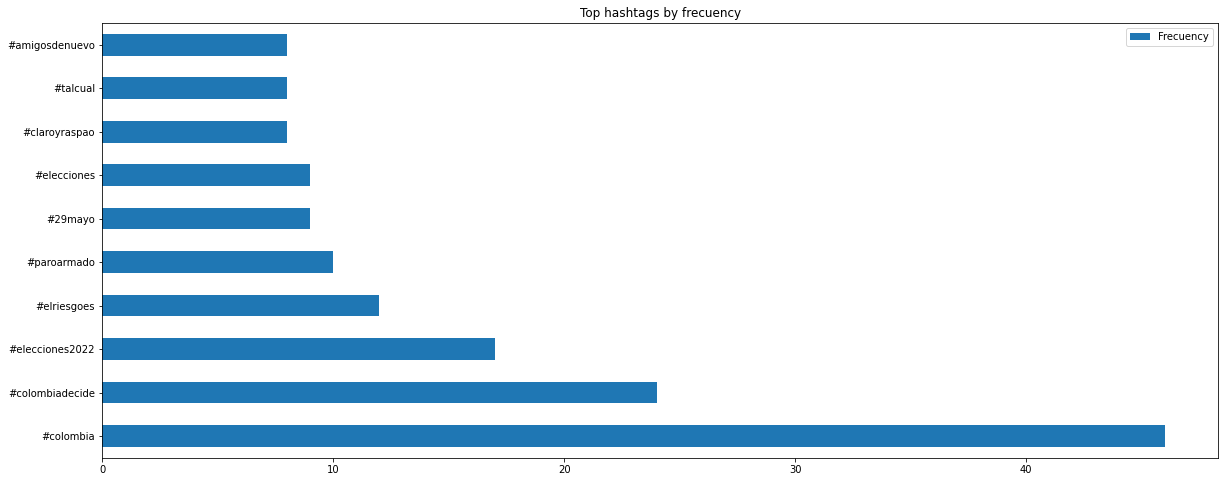

In [14]:
ax = hashtags_df.plot(kind = 'barh', figsize = (20, 8))
ax.set_yticklabels(hashtags_df['Hashtag'])
plt.title('Top hashtags by frecuency')
plt.show()

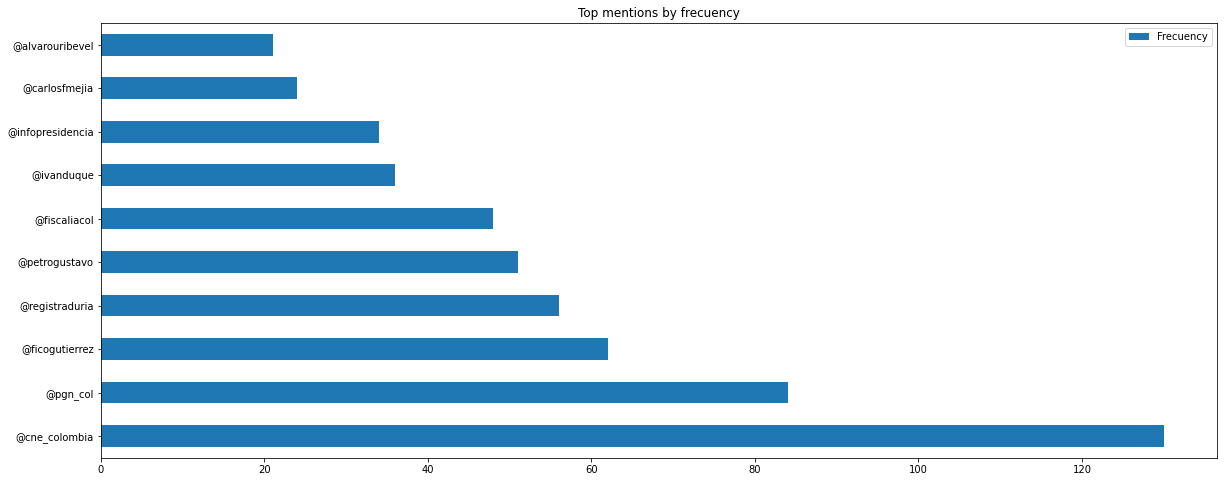

In [15]:
ax = mentions_df.plot(kind = 'barh', figsize = (20, 8))
ax.set_yticklabels(mentions_df['Mention'])
plt.title('Top mentions by frecuency')
plt.show()

### Creating and using text index

In [16]:
HISTORY_COL.create_index([('full_text', pymongo.TEXT)], default_language = 'spanish')

'full_text_text'

In [17]:
tweets = HISTORY_COL.find(
   { '$text': { '$search': 'petro atentado' } },
   { 'score': { '$meta': 'textScore' } }
).sort([('score', {'$meta': 'textScore'})])

In [18]:
tweets.count()

/Users/fabian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  """Entry point for launching an IPython kernel.


143

In [19]:
for tweet in tweets[:5]:
    print('Text:', tweet['full_text'])
    print('Score:', tweet['score'])
    print('\n')

Text: @bpmacias @PaulaBayarte @InesAmarelo @JavierCBugarin @carlasamon 🇨🇴 Un posible atentado contra el candidato Gustavo Petro preocupa a Colombia a tres semanas de las elecciones. 🗳

https://t.co/u7OwKlgtiA https://t.co/4vI8OFEnwS
Score: 1.04


Text: https://t.co/XgHuyrM1ZI 
#ElRiesgoEs QUE SE EXTIENDA EL #ParoArmado DE PETRO HASTA LAS ELECCIONES PARA EVITAR QUE COLOMBIA VOTE CONTRA PETRO

PERO, EL PARO ES DEL CLAN DEL GOLFO - OTONIEL

...

CLAN DEL GOLFO TRABAJA PAR EL CÁRTEL NARCOTERRORISTA FARC omunes

OSEA SI ES DE PETRO!
Score: 0.96875


Text: ¡Viva Petro!
Colombia | Petro anuncia que si gana restablecerá las relaciones diplomáticas y consulares con Venezuela @InfoNodal https://t.co/VjYoQsWoY1
Score: 0.8382352941176471


Text: @CoronelBillKil1 El tipo más demócrata de Colombia es Petro. No solo le robaron las elecciones de hace 4 años ,sino que el estamento no se ha encargado sino de perseguirlo con sanciones y faltas investigaciones. Todo lo ha ganado Petro
Score: 0.82142857142

### Analyzing time

In [20]:
tweets = HISTORY_COL.find({}, {'created_at': True})

In [21]:
creation_dates = []
for tweet in tweets:
    try:
        creation_dates.append(tweet['created_at'])
    except:
        pass

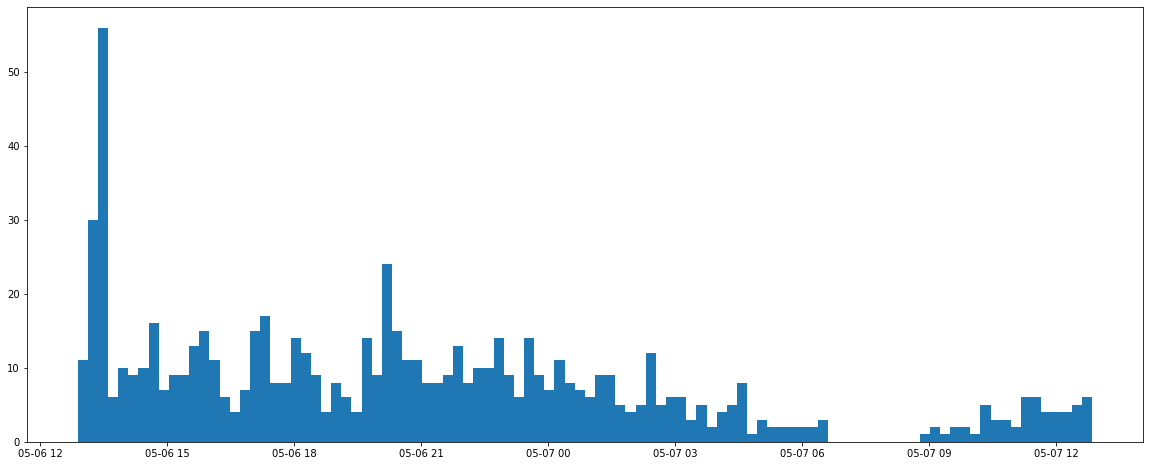

In [22]:
plt.figure(figsize = (20, 8))
plt.hist(creation_dates, bins = 100)
plt.show()